In [ ]:
#| default_exp laziness

In [ ]:
#| include: false
from numpy.lib.function_base import average
from nbdev.showdoc import *
import numpy as np
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import numpy as np
def curvature(P, diffusion_powers=8, aperture = 20, smoothing=1, verbose = False, return_density = False, dynamically_adjusting_neighborhood = False, precomputed_powered_P = None, non_lazy_diffusion=False, restrict_diffusion_to_k_neighborhood=None, avg_transition_probability=True, use_min_threshold = False):
    """Diffusion Laziness Curvature
    Estimates curvature by measuring the amount of mass remaining within an initial neighborhood after t steps of diffusion. Akin to measuring the laziness of a random walk after t steps.

    Parameters
    ----------
    P : n x n ndarray
        The diffusion matrix of the graph
    diffusion_powers : int, optional
        Number of steps of diffusion to take before measuring the laziness, by default 8
    aperture : int, optional
        The size of the initial neighborhood, from which the percentage of mass remaining in this neighborhood is calculated, by default 20
    smoothing : int, optional
        Amount of smoothing to apply. Currently works by multiplying the raw laziness values with the diffusion operator, as a kind of iterated weighted averaging; by default 1
    verbose : bool, optional
        Print diagnostics, by default False
    return_density : bool, optional
        Return the number of neighbors each point shares, by default False
    dynamically_adjusting_neighborhood : bool, optional
        Whether to give each point the same initial neighborhood size, by default False
    precomputed_powered_P : ndarray, optional
        Optionally pass a precomputed powered diffusion operator, to speed up computation, by default None
    avg_transition_probability: bool, default True
        Use the definition of diffusion curvature in which the summed transition probabilities are divided by the total number of points in the aperture neighborhood.
        As a result, gives not the summed "return probability within the neighborhood" but the average return probability to each point in the aperture neighborhood.
        This formulation of diffusion curvature was used in proof given in our NeurIPS 2022 paper.

    Returns
    -------
    length n array
        The laziness curvature values for each point
    """
    # the aperture sets the size of the one-hop neighborhood 
    # the aperture parameter is the average number of neighbors to include, based off of the sorted diffusion values
    # Set thresholds as the kth largest diffusion value, presumed to be held by the kth nearest neighbor.
    thresholds = np.partition(P,-aperture)[:,-aperture]
    # thresholds = np.sort(P)[:,-aperture] 
    if verbose: print(thresholds)
    if dynamically_adjusting_neighborhood:
        P_thresholded = (P >= thresholds[:,None]).astype(int)
    else:
        if use_min_threshold:
            P_threshold = np.min(thresholds)
        else:
            P_threshold = np.mean(thresholds) # TODO could also use min
        P_thresholded = (P >= P_threshold).astype(int)
        if verbose: print("Derived threshold ",P_threshold)

    if verbose: print(np.sum(P_thresholded,axis=1))
    if verbose: print("Performing matrix powers...")
    
    if precomputed_powered_P is not None:
        P_powered = precomputed_powered_P
    elif non_lazy_diffusion:
        print("Removing self-diffusion")
        P_zero_diagonal = (np.ones_like(P) - np.diag(np.ones(len(P))))*P
        D = np.diag(1/np.sum(P_zero_diagonal,axis=0))
        P = D @ P_zero_diagonal
        P_powered = np.linalg.matrix_power(P,diffusion_powers)
    else:
        P_powered = np.linalg.matrix_power(P,diffusion_powers)
    # take the diffusion probs of the neighborhood
    near_neighbors_only = P_powered * P_thresholded
    laziness_aggregate = np.sum(near_neighbors_only,axis=1)
    if avg_transition_probability:
        ones_matrix = np.ones_like(P_thresholded)
        ones_remaining = ones_matrix * P_thresholded
        local_density = np.sum(ones_remaining,axis=1)
        if verbose: print("local density",local_density)
        # divide by the number of neighbors diffused to
        # TODO: In case of isolated points, replace local density of 0 with 1. THe laziness will evaluate to zero.
        local_density[local_density==0]=1
        laziness_aggregate = laziness_aggregate / local_density
    laziness = laziness_aggregate
    if smoothing: # TODO there are probably more intelligent ways to do this smoothing
        # Local averaging to counter the effects local density
        if verbose: print("Applying smoothing...")
        smoothing_P_powered = np.linalg.matrix_power(P,smoothing)
        average_laziness = smoothing_P_powered @ laziness_aggregate[:,None]
        average_laziness = average_laziness.squeeze()
        laziness = average_laziness
    if return_density:
        # compute sums of neighbors taken into consideration
        ones_matrix = np.ones_like(P_thresholded)
        ones_remaining = ones_matrix * P_thresholded
        local_density = np.sum(ones_remaining,axis=1)
        return laziness, local_density
    return laziness

In [ ]:
show_doc(curvature)

---

[source](https://github.com/professorwug/diffusion_curvature/blob/master/diffusion_curvature/laziness.py#L8){target="_blank" style="float:right; font-size:smaller"}

### curvature

>      curvature (P, diffusion_powers=8, aperture=20, smoothing=1,
>                 verbose=False, return_density=False,
>                 dynamically_adjusting_neighborhood=False,
>                 precomputed_powered_P=None, non_lazy_diffusion=False,
>                 restrict_diffusion_to_k_neighborhood=None,
>                 avg_transition_probability=True, use_min_threshold=False)

Diffusion Laziness Curvature
Estimates curvature by measuring the amount of mass remaining within an initial neighborhood after t steps of diffusion. Akin to measuring the laziness of a random walk after t steps.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| P | n x n ndarray |  | The diffusion matrix of the graph |
| diffusion_powers | int | 8 | Number of steps of diffusion to take before measuring the laziness, by default 8 |
| aperture | int | 20 | The size of the initial neighborhood, from which the percentage of mass remaining in this neighborhood is calculated, by default 20 |
| smoothing | int | 1 | Amount of smoothing to apply. Currently works by multiplying the raw laziness values with the diffusion operator, as a kind of iterated weighted averaging; by default 1 |
| verbose | bool | False | Print diagnostics, by default False |
| return_density | bool | False | Return the number of neighbors each point shares, by default False |
| dynamically_adjusting_neighborhood | bool | False | Whether to give each point the same initial neighborhood size, by default False |
| precomputed_powered_P | NoneType | None | Optionally pass a precomputed powered diffusion operator, to speed up computation, by default None |
| non_lazy_diffusion | bool | False |  |
| restrict_diffusion_to_k_neighborhood | NoneType | None |  |
| avg_transition_probability | bool | True |  |
| use_min_threshold | bool | False |  |
| **Returns** | **length n array** |  | **The laziness curvature values for each point** |

# Examples

## Torus with Adaptive Kernel

### Without Dynamic Neighborhood Selection

In [ ]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.core import DiffusionMatrix
X, ks = torus(n=5000)
P = DiffusionMatrix(X,kernel_type="adaptive",k=20)

Let's visualize a single diffusion here:

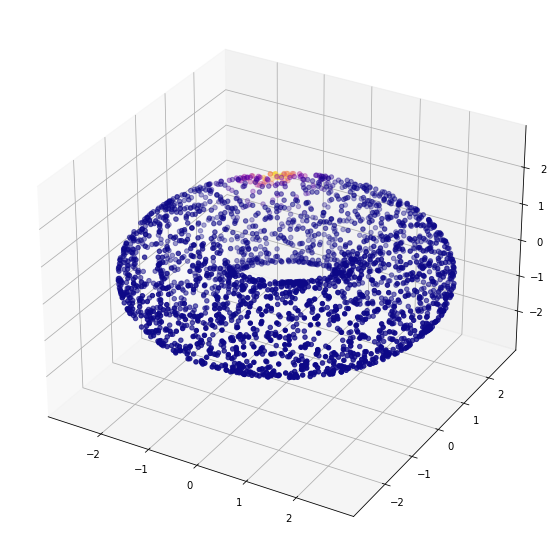

In [ ]:
from diffusion_curvature.core import plot_3d
plot_3d(X,P[0])

Looks fairly good. It's too small to bleed across the torus, so it should emphasize the step-wise nature of the random-walk laziness calculation.

In [ ]:
ks = curvature(P,diffusion_powers=1,aperture=20,dynamically_adjusting_neighborhood=False)

The indication that this method is working is that it *doesn't* work for a single power of diffusion, but *does* work for higher powers of diffusion.

Any correlation with curvature after a single power of diffusion is accidental -- arising from density, or geometry. In the torus, we must be careful, as the number of neighbors included can alone influence the outcome of the laziness -- with more neighbors likely to be included in the inside ring of the torus.

So, here's the (hopefully) un-correlated single-step laziness.

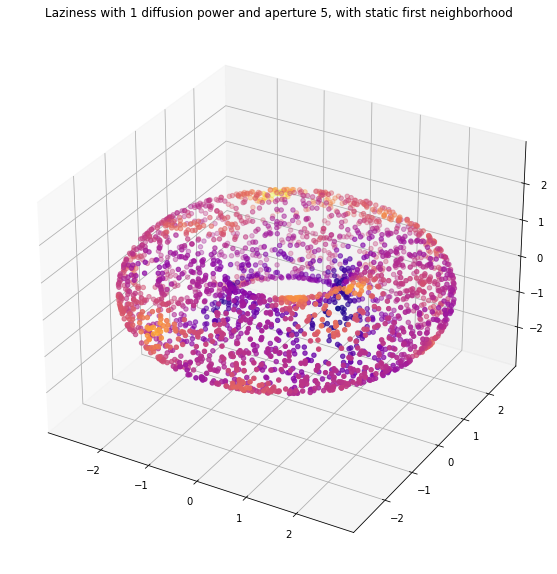

In [ ]:
plot_3d(X,ks,title="Laziness with 1 diffusion power and aperture 5, with static first neighborhood")

Here we see some patchy correlation with curvature -- it seems that the inside saddle of the torus influences the shape of the diffusion power to the extent that it is noticeable. However, the rest of the torus is spotty.

Let's try higher diffusion steps.

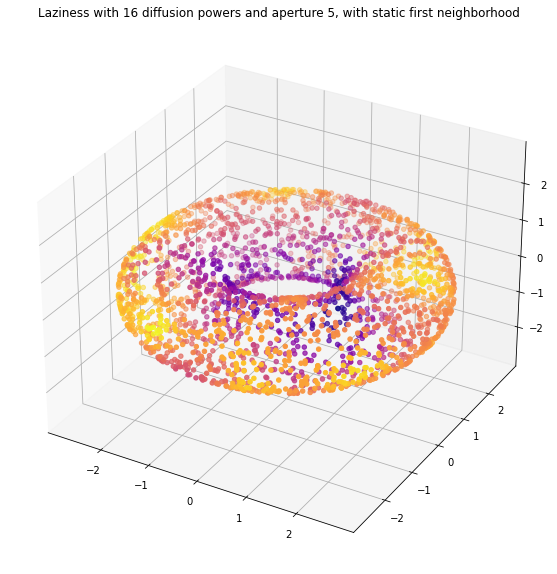

In [ ]:
t = 16
ks = curvature(P,diffusion_powers=t,aperture=5,dynamically_adjusting_neighborhood=False)
plot_3d(X,ks,title=f"Laziness with {t} diffusion powers and aperture 5, with static first neighborhood")

A higher diffusion power has elimated some of the patches, but not all of them.

This emphasizes that the density variations still contribute to significant local variations in the reported curvature. 

Let's try a means of addressing this via a fancier kernel.

## Torus with Adaptive Anisotropic Kernel

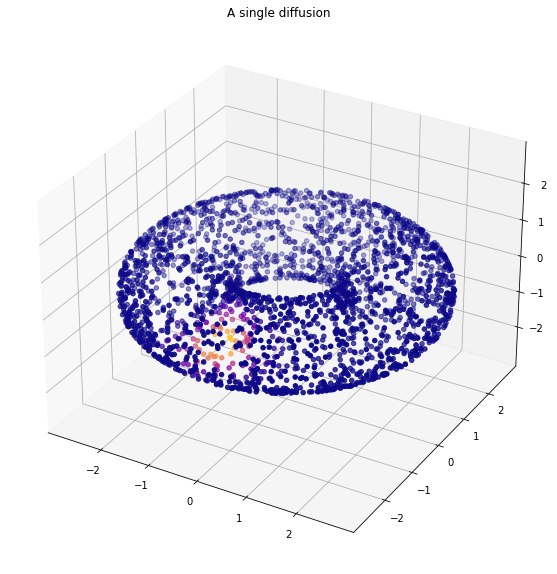

In [ ]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.core import DiffusionMatrix
X,ks = torus(n=5000)
P_anis = DiffusionMatrix(X,kernel_type="adaptive anisotropic",k=20)
plot_3d(X,P_anis[0],"A single diffusion")

Let's see what a single diffusion step looks like here. Theoretically, the density normalization should diminish the initial patterns.

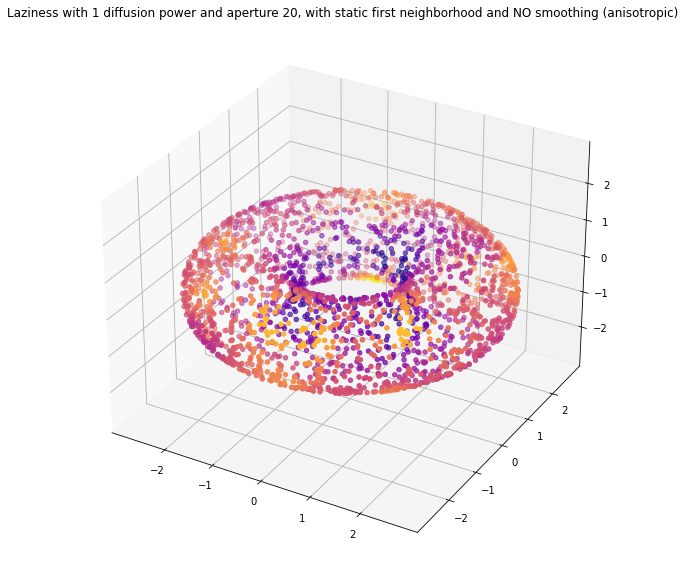

In [ ]:
ks = curvature(P_anis,diffusion_powers=1,aperture=20,dynamically_adjusting_neighborhood=False,smoothing=1)
plot_3d(X,ks,title="Laziness with 1 diffusion power and aperture 20, with static first neighborhood and NO smoothing (anisotropic)")

Indeed, it anecdotally seems less visible.
Here's the full 16 powers:

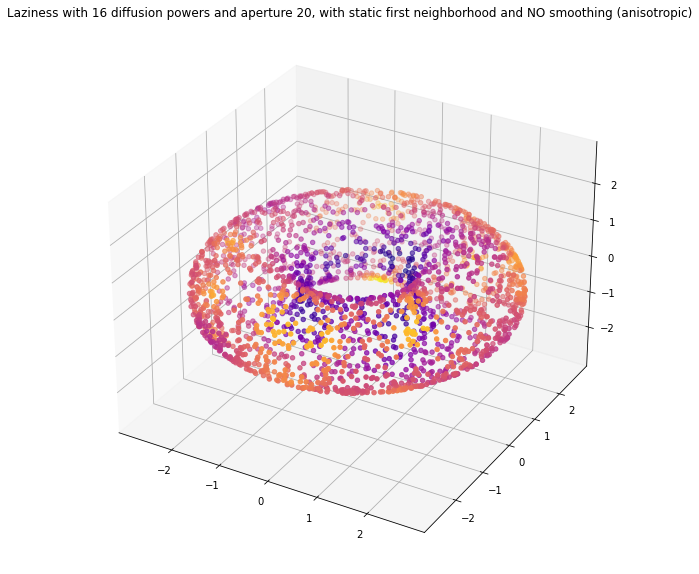

In [ ]:
ks = curvature(P_anis,diffusion_powers=1,aperture=20,dynamically_adjusting_neighborhood=False,smoothing=1)
plot_3d(X,ks,title="Laziness with 16 diffusion powers and aperture 20, with static first neighborhood and NO smoothing (anisotropic)")

Notice that this is much choppier a curvature value than the non-anisotropic adaptive kernel.
We need additional powers of diffusion to recover the previous semblance of order.

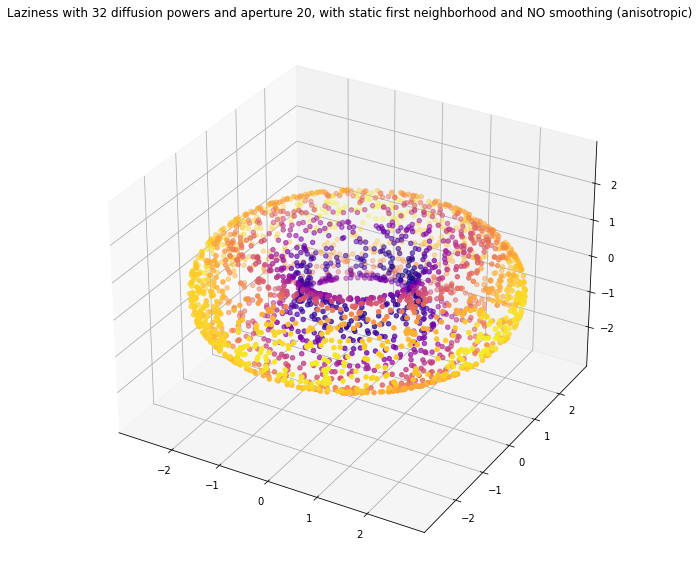

In [ ]:
ks = curvature(P_anis,diffusion_powers=32,aperture=20,dynamically_adjusting_neighborhood=False,smoothing=1, avg_transition_probability=True)
plot_3d(X,ks,title="Laziness with 32 diffusion powers and aperture 20, with static first neighborhood and NO smoothing (anisotropic)")

# With Non-lazy Diffusion
Set the parameter `non_lazy_diffusion` to true, and the laziness curvature method will delete the diagonal of self-diffusion, and then renormalize the diffusion matrix. This will motivate the diffusion mass to move, and (one hopes) will reduce the number of steps necessary for the laziness to track with the curvature.

In order to examine this parameter, we'll import a method from the future -- the "laziness decay graph". We'll create a laziness decay graph of the torus with a minimally connected diffusion matrix, with and without non-lazy diffusion.

In [ ]:
from diffusion_curvature.laziness import laziness_decay

ImportError: cannot import name 'laziness_decay' from 'diffusion_curvature.laziness' (/Users/adjourner/Documents/4 SRC/4.21 SUMRY Curvature/diffusion_curvature_nbdev2/diffusion_curvature/laziness.py)

In [ ]:
X, ks = torus(n=5000,seed=42)
P = DiffusionMatrix(X,kernel_type='adaptive',k=5)
decaying_lazy = laziness_decay(P, max_steps=60,aperture=5,adaptive_neighborhood=True,non_lazy_diffusion=False)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(15,15))
ax.plot(decaying_lazy[0],color='green',label='Positive')
ax.plot(decaying_lazy[2],color='blue',label='Zero')
ax.plot(decaying_lazy[1],color='red',label='Negative')
ax.legend()
ax.set_title("Without Non-lazy Diffusions")
ax.set_xlabel("Diffusion Time Steps")
ax.set_ylabel("Laziness")

Now for the same thing with non-lazy diffusions.

In [ ]:
decaying_lazy = laziness_decay(P, max_steps=60,aperture=5,adaptive_neighborhood=True,non_lazy_diffusion=True)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(15,15))
ax.plot(decaying_lazy[0],color='green',label='Positive')
ax.plot(decaying_lazy[2],color='blue',label='Zero')
ax.plot(decaying_lazy[1],color='red',label='Negative')
ax.legend()
ax.set_title("With Non-Lazy Diffusions")
ax.set_xlabel("Diffusion Time Steps")
ax.set_ylabel("Laziness")

Interesting. Removing the self-diffusion has a marked effect on the separation of the three states. It seems to impact negative curvature most, causing it to more rapidly dip below the others from the very first diffusion.

As might be expected, the contest between zero and positive curvature continues to take longer to resolve, though this method appears to help somewhat.